**Problema**

- time de growth investiu para aumentar o numero de pedidos
- mas começaram a ver que a nota média começou a cair
- agora eles estão com medo de perder a reputação
    - por conta de nao conseguir lidar com a demanda
    
**Objetivo**
- identificar o problema
    - dizer se devem parar
    - ou se existe um plano B a seguir

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from ipywidgets import interact
import holidays
from datetime import datetime, timedelta, date

In [2]:
pd.set_option('display.max_columns', None)

plt.figure(figsize=(15,5));
sns.set(rc={'figure.figsize':(15,5), 'xtick.direction':'in'});

<Figure size 1080x360 with 0 Axes>

In [3]:
def cfg_plot(title='', xlabel='', ylabel='', rotation=0):
    plt.xticks(rotation=rotation)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [4]:
df = pd.read_excel("Zé Delivery Data Base_versionD (3).xlsx")

In [5]:
df_reasons = pd.read_excel("Zé Delivery Data Base_versionD (3).xlsx", sheet_name='Bad Rating reasons')

In [6]:
df = df.merge(df_reasons, how='left', on='Order ID', suffixes=('', '_r'))

In [7]:
del df['Order Number_r']
del df['Rating_r']

# Knowing the dataset

In [8]:
df.head()

Order ID  Order Number  Week         Date & Time Comment             User  \
0    191357         14027     1 2017-01-01 10:11:01     NaN   user7gmail.com   
1    191361         14031     1 2017-01-01 11:39:28     NaN  user11gmail.com   
2    191362         14032     1 2017-01-01 12:22:29     NaN  user12gmail.com   
3    191384         14054     1 2017-01-01 15:35:10     NaN  user33gmail.com   
4    191385         14055     1 2017-01-01 16:02:38     NaN  user34gmail.com   

   Merchandise Revenue Payment Method  POC ID  Rating  Reasons Shipping Type  \
0              105.120            NaN      26     5.0      NaN       receber   
1               70.848            NaN      30     5.0      NaN       receber   
2               62.304            NaN      26     NaN      NaN       receber   
3               48.816            NaN      29     1.0      NaN       receber   
4               70.848            NaN      30     5.0      NaN       receber   

  State rating_datetime rating_reasons  
0    SP             NaT            NaN  
1    SP             NaT            NaN  
2    SP             NaT            NaN  
3    SP             NaT            NaN  
4    SP             NaT            NaN

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11259 entries, 0 to 11258
Data columns (total 15 columns):
Order ID               11259 non-null int64
Order Number           11259 non-null int64
Week                   11259 non-null int64
Date & Time            11259 non-null datetime64[ns]
Comment                127 non-null object
User                   11257 non-null object
Merchandise Revenue    11259 non-null float64
Payment Method         5990 non-null object
POC ID                 11259 non-null int64
Rating                 5134 non-null float64
Reasons                0 non-null float64
Shipping Type          11259 non-null object
State                  11239 non-null object
rating_datetime        215 non-null datetime64[ns]
rating_reasons         97 non-null object
dtypes: datetime64[ns](2), float64(3), int64(4), object(6)
memory usage: 1.4+ MB


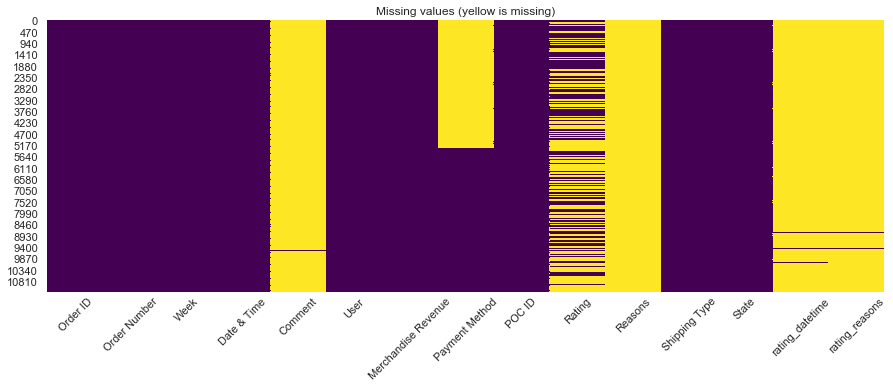

In [10]:
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
cfg_plot('Missing values (yellow is missing)', '', '', 45)

In [11]:
print('Numeric and date summary:\n')
for col in df.columns:
    if df[col].dtype != 'object':
        print('{} ---> Min: {} | Max: {} | Unique count: {} | % NaN: {}'.format(
            col,
            min(df[col]),
            max(df[col]),
            df[col].unique().size,
            round(df[col].isnull().sum()/df[col].size, 2)
        ))

Numeric and date summary:

Order ID ---> Min: 45 | Max: 256243 | Unique count: 11259 | % NaN: 0.0
Order Number ---> Min: 14027 | Max: 99998981 | Unique count: 11259 | % NaN: 0.0
Week ---> Min: 1 | Max: 45 | Unique count: 45 | % NaN: 0.0
Date & Time ---> Min: 2017-01-01 10:11:01 | Max: 2017-10-31 23:42:43 | Unique count: 11222 | % NaN: 0.0
Merchandise Revenue ---> Min: -19.296000000000003 | Max: 6894.528 | Unique count: 2755 | % NaN: 0.0
POC ID ---> Min: 17 | Max: 74 | Unique count: 51 | % NaN: 0.0
Rating ---> Min: -1.0 | Max: 5.0 | Unique count: 7 | % NaN: 0.54
Reasons ---> Min: nan | Max: nan | Unique count: 1 | % NaN: 1.0
rating_datetime ---> Min: NaT | Max: NaT | Unique count: 216 | % NaN: 0.98


- Order e Number ID possuem um valor para cada linha
- POC ID tem mais de um (é a revenda)

In [12]:
print('Text summary:\n')
for col in df.columns:
    if df[col].dtype == 'object':
        print('{} ---> Unique count: {} | % NaN: {}'.format(
            col,
            df[col].unique().size,
            round(df[col].isnull().sum()/df[col].size, 2)
        ))

Text summary:

Comment ---> Unique count: 115 | % NaN: 0.99
User ---> Unique count: 7601 | % NaN: 0.0
Payment Method ---> Unique count: 6 | % NaN: 0.47
Shipping Type ---> Unique count: 3 | % NaN: 0.0
State ---> Unique count: 45 | % NaN: 0.0
rating_reasons ---> Unique count: 8 | % NaN: 0.99


# Data transform

## Transforming States

In [13]:
df.State.unique()

array(['SP', 'RJ', 'MG', 'CE', 'PR', 'Campinas', 'São Paulo', 'Fortaleza',
       'São José do Rio Preto', 'Rio de Janeiro', 'S',
       'São Bernardo do Campo', 'Diadema', 'Belo Horizonte', nan,
       'Santo André', 'Curitiba', 'Betim', 'São José dos Campos',
       'Nova Iguaçu', 'Niter', 'Sao Paulo', 'São Caetano do Sul',
       'Nova Igua', 'Niterói', 'Guarulhos', 'Embu', 'Poços de Caldas',
       'Santo Andr', 'Itaquaquecetuba', 'Belford Roxo', 'Mesquita',
       'Contagem', 'Colombo', 'undefined', 'Osasco', 'Carapicuíba',
       'Embu das Artes', 'Taboão da Serra', 'Ferraz de Vasconcelos',
       'Pinhais', 'São Carlos', 'Maracanaú', 'Barueri', 'Nova Lima'],
      dtype=object)

In [14]:
states_dict = {
    'Campinas': 'SP',
    'São Paulo': 'SP',
    'Fortaleza': 'CE',
    'São José do Rio Preto': 'SP',
    'Rio de Janeiro': 'RJ',
    'S': 'NA',
    'São Bernardo do Campo': 'SP',
    'Diadema': 'SP',
    'Belo Horizonte': 'MG',
    np.nan: 'NA',
    'Santo André':'SP',
    'Curitiba': 'PR',
    'Betim': 'MG',
    'São José dos Campos': 'SP',
    'Nova Iguaçu': 'RJ',
    'Niter': 'RJ',
    'Sao Paulo': 'SP',
    'São Caetano do Sul': 'SP',
    'Nova Igua': 'RJ',
    'Niterói': 'RJ',
    'Guarulhos': 'SP',
    'Embu': 'SP',
    'Poços de Caldas': 'MG',
    'Santo Andr': 'SP',
    'Itaquaquecetuba': 'SP',
    'Belford Roxo': 'RJ',
    'Mesquita': 'RJ',
    'Contagem': 'MG',
    'Colombo': 'PR',
    'undefined': 'NA',
    'Osasco': 'SP',
    'Carapicuíba': 'SP',
    'Embu das Artes': 'SP',
    'Taboão da Serra': 'SP',
    'Ferraz de Vasconcelos': 'SP',
    'Pinhais': 'PR',
    'São Carlos': 'SP',
    'Maracanaú': 'CE',
    'Barueri': 'SP',
    'Nova Lima': 'MG'
}

In [15]:
df.State.apply(lambda x: states_dict.get(x, x)).unique()

array(['SP', 'RJ', 'MG', 'CE', 'PR', 'NA'], dtype=object)

In [16]:
df['State'] = df.State.apply(lambda x: states_dict.get(x, x))

In [17]:
df['State'].value_counts()

SP    7548
RJ    2171
MG     705
NA     522
PR     162
CE     151
Name: State, dtype: int64

# Look into column

## Rating column

In [18]:
df['Rating'].unique()

array([ 5., nan,  1.,  3.,  4.,  2., -1.])

In [19]:
rating = df['Rating'].fillna('NA')
rating.unique()

array([5.0, 'NA', 1.0, 3.0, 4.0, 2.0, -1.0], dtype=object)

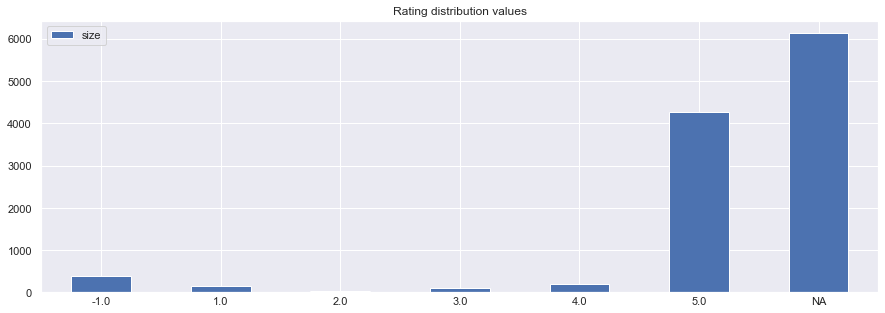

In [20]:
rating.groupby(rating).agg(['size']).plot(kind='bar')
cfg_plot('Rating distribution values', '', '')

In [21]:
rating.isin([1.0, 2.0, 3.0, 4.0, 5.0]).value_counts(normalize=True)

False    0.578115
True     0.421885
Name: Rating, dtype: float64

## Date and Time column

### Date info

In [22]:
#https://stackoverflow.com/questions/16139306/determine-season-given-timestamp-in-python-using-datetime

Y = 2017 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

In [23]:
br_holidays = holidays.Brazil(years=[2017])

In [24]:
before_holiday = [keys - timedelta(days=1) for keys in br_holidays]
after_holiday = [keys + timedelta(days=1) for keys in br_holidays]

In [25]:
df['dt_year'] = df['Date & Time'].dt.year
df['dt_month'] = df['Date & Time'].dt.month
df['dt_month_name'] = df['Date & Time'].dt.month_name()
df['dt_day'] = df['Date & Time'].dt.day
df['dt_week'] = df['Date & Time'].dt.week
df['dt_dayofweek'] = df['Date & Time'].dt.dayofweek
df['dt_is_holiday'] = df['Date & Time'].dt.date.apply(lambda x: x in br_holidays)
df['dt_is_before_holiday'] = df['Date & Time'].dt.date.apply(lambda x: x in before_holiday)
df['dt_is_after_holiday'] = df['Date & Time'].dt.date.apply(lambda x: x in after_holiday)
df['season'] = df['Date & Time'].apply(get_season)

### Time info

In [26]:
df['tm_hour'] = df['Date & Time'].dt.hour

In [27]:
#df.to_csv('tratado.csv')

# Validating hypotesis

*In July ’17 the platform in which Zé Delivery operates was changed to a new one we developed in-house. That coincide with the same period the order rating started to drop.*

- It realy happened in July?
    - Yes
- Which state?
    - Almost all States (unless PR)
    - But SP (\~3/4) and RJ (\~1/4) have the most of data. Other States have few data.
    - Insight: some States was identified as NA. This happened from July only. Month that operates changed. ` ------------> **DRILL DOWN HERE!!!**`
- Which day starts to fall down?

*The rating can have 7 numbers in the data field: 1, 2, 3, 4 and 5 that represents the stars the user gave; we input the -1 tags on the data field if the user chooses to skip the rating, and blank or 0, if the user didn’t receive the rating request yet. Those last 3 are not considered in our average order rating.*

*The email for the rating request wasn’t implemented in this new platform, but we had it on the old platform*
- We haven't 0 in our dataset

In [28]:
df.head(1)

Order ID  Order Number  Week         Date & Time Comment            User  \
0    191357         14027     1 2017-01-01 10:11:01     NaN  user7gmail.com   

   Merchandise Revenue Payment Method  POC ID  Rating  Reasons Shipping Type  \
0               105.12            NaN      26     5.0      NaN       receber   

  State rating_datetime rating_reasons  dt_year  dt_month dt_month_name  \
0    SP             NaT            NaN     2017         1       January   

   dt_day  dt_week  dt_dayofweek  dt_is_holiday  dt_is_before_holiday  \
0       1       52             6           True                 False   

   dt_is_after_holiday  season  tm_hour  
0                False  winter       10

In [29]:
df_h1 = df[['Rating', 'State', 'Date & Time', 'POC ID','rating_reasons'] + [col for col in df.columns if 'dt_' in col] + [col for col in df.columns if 'tm_' in col]]

In [30]:
# get only valid rating
df_h1 = df_h1[df_h1['Rating'].isin([1.0, 2.0, 3.0, 4.0, 5.0])]

In [31]:
rating_all = df_h1.groupby(['dt_month', 'dt_month_name'])['Rating'].mean().reset_index()

In [32]:
df_h1_month = df_h1.groupby(['dt_month_name', 'dt_month', 'State'])['Rating'].mean().reset_index()

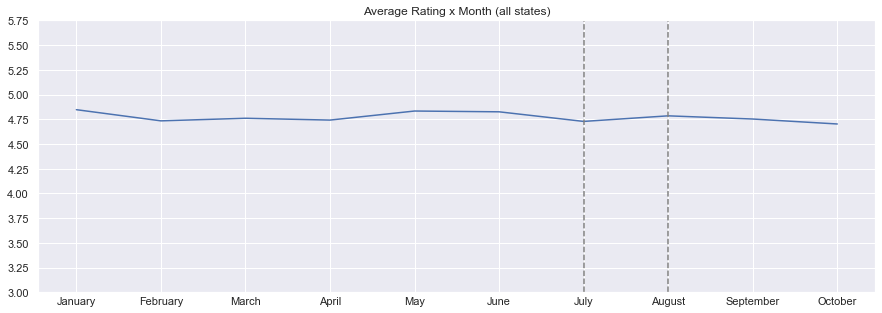

In [33]:
ax = sns.lineplot(x="dt_month", y="Rating", data=rating_all)
plt.xticks(df_h1_month.dt_month.unique())
plt.yticks(np.arange(3, 6, 0.25))
ax.set_xticklabels(df_h1_month.dt_month_name.unique())
plt.axvline(7, color='gray', linestyle='--')
plt.axvline(8, color='gray', linestyle='--')

cfg_plot('Average Rating x Month (all states)')

Queda bruta em Julho. Então, a queda realmente aconteceu em Julho. Quanto foi a queda percentual de um mes para o outro?

In [34]:
rating_all['%_last_month'] = round((rating_all.Rating/rating_all.Rating.shift(1).fillna(0) -1)*100, 2).replace(np.inf, 0)

In [35]:
rating_all

dt_month dt_month_name    Rating  %_last_month
0         1       January  4.847222          0.00
1         2      February  4.734139         -2.33
2         3         March  4.760417          0.56
3         4         April  4.741985         -0.39
4         5           May  4.833605          1.93
5         6          June  4.825641         -0.16
6         7          July  4.728495         -2.01
7         8        August  4.784946          1.19
8         9     September  4.752672         -0.67
9        10       October  4.702532         -1.05

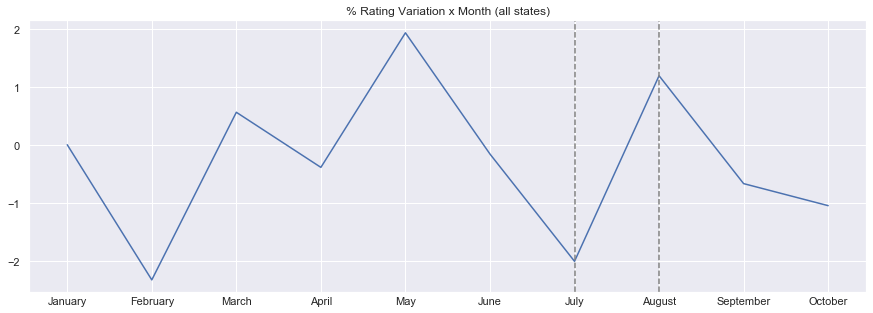

In [36]:
ax = sns.lineplot(y="%_last_month", x="dt_month", data=rating_all)
plt.xticks(df_h1_month.dt_month.unique())
ax.set_xticklabels(df_h1_month.dt_month_name.unique())
plt.axvline(7, color='gray', linestyle='--')
plt.axvline(8, color='gray', linestyle='--')
cfg_plot('% Rating Variation x Month (all states)')

De Junho pra Julho a queda foi de 2.01%. Valor alto, porém de Janeiro para Fevereiro houve queda mais brusca inclusive.

E por estado, essa queda também aconteceu da mesma forma?

In [37]:
@interact(state=df_h1_month.State.unique())
def plot_rating_state(state):
    ax = sns.lineplot(x="dt_month", y="Rating", hue='State', data=df_h1_month[df_h1_month.State==state], legend=False)
    ax.set_xticklabels(df_h1_month.dt_month_name.unique())
    plt.xticks(df_h1_month.dt_month.unique())
    plt.yticks(np.arange(4.0, 5.25, 0.05))
    plt.axvline(7, color='gray', linestyle='--')
    plt.axvline(8, color='gray', linestyle='--')
    
    ax2 = sns.lineplot(x="dt_month", y="Rating", data=rating_all, alpha=0.5)
    cfg_plot('Average Rating x Month x State')

interactive(children=(Dropdown(description='state', options=('CE', 'MG', 'PR', 'RJ', 'SP', 'NA'), value='CE'),…

Apenas SP e RJ. Os outros estados tem comportamentos diferentes. Onde está a maioria dos dados?

In [38]:
df_h1.groupby(['State'])['Rating'].agg(['size','mean']).reset_index().sort_values(['State'])

State  size      mean
0    CE    80  4.775000
1    MG   312  4.817308
2    NA   149  4.684564
3    PR    72  4.777778
4    RJ   941  4.853348
5    SP  3196  4.745307

- a ação funcionou apenas no primeiro mes, mas no mes seguinte não conseguiu manter

In [39]:
july_h1 = df_h1[df_h1['dt_month']==7]

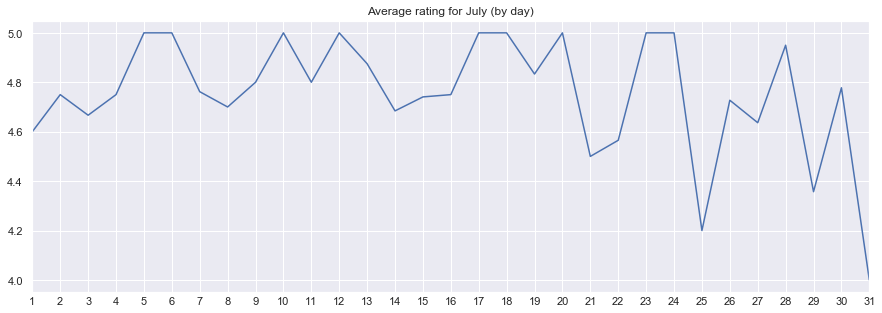

In [40]:
july_h1.groupby(['dt_day']).mean()['Rating'].plot()
plt.xticks(july_h1.dt_day.unique())
cfg_plot('Average rating for July (by day)')

- Parece que existe um padrão: a cada mais ou menos 5 dias, existe um pico
- Dia 25 houve queda de 5 para 4.2
- Dia 31 houve queda de 4.8 para 4.0
- Do dia 24 ao 30 houve queda de 5 para 4.0

Os outros meses acontece essa variação a cada 5 dias?

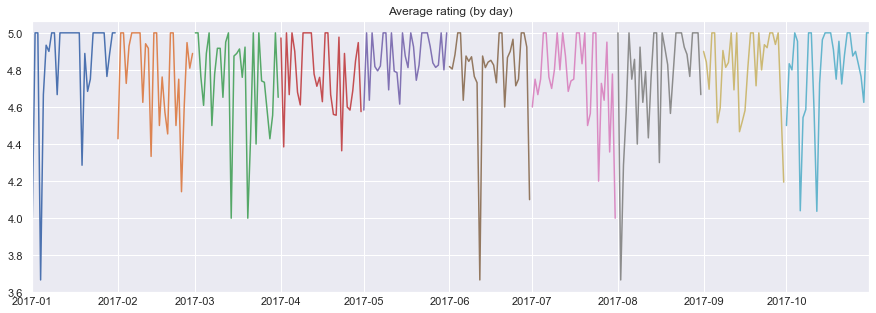

In [41]:
for month in df_h1.dt_month.unique():
    df_h1.groupby(df_h1[df_h1['dt_month']==month]['Date & Time'].dt.date).mean()['Rating'].plot()
cfg_plot('Average rating (by day)')

In [42]:
@interact(month=df_h1.dt_month.unique())
def plot_rating_day_month(month):
    ax = df_h1.groupby(df_h1[df_h1['dt_month']==month]['Date & Time'].dt.date).mean()['Rating'].plot()
    plt.yticks(np.arange(0, 6, 0.5))
    cfg_plot('Average Rating x Month x State')

interactive(children=(Dropdown(description='month', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=1), Output(…

In [43]:
test = df_h1.groupby([df_h1['Date & Time'].dt.date, 'dt_month', 'dt_dayofweek']).mean()['Rating'].reset_index()
test

Date & Time  dt_month  dt_dayofweek    Rating
0    2017-01-01         1             6  4.000000
1    2017-01-02         1             0  5.000000
2    2017-01-03         1             1  5.000000
3    2017-01-04         1             2  3.666667
4    2017-01-05         1             3  4.666667
..          ...       ...           ...       ...
297  2017-10-27        10             4  4.833333
298  2017-10-28        10             5  4.764706
299  2017-10-29        10             6  4.625000
300  2017-10-30        10             0  5.000000
301  2017-10-31        10             1  5.000000

[302 rows x 4 columns]

- Em julho houve a troca da operação e agosto houve a ação para melhorar. Porém, não é um padrão que difere muito do que já aconteceu no passado
- Exitem picos, a maioria entre 4 e 4.2 e alguns mais acentuados que ficam entre 3.6 e 3.8
- Olhando a série histórica, diria que houve sim uma diminuição de Julho para agosto, mas que isso talvez não seja o fim do mundo. Setembro está sob efeito da ação de Agosto, com Outubro com várias baixas mas não acho que seja muito anormal.


- Em Outubro houveram 3 picos negativos
    - A campanha estava rodando ainda?
    - Note que o pico é de um dia para o outro
        - O que causa?
            - Software?
            - Muita demanda? (final de semana, etc)

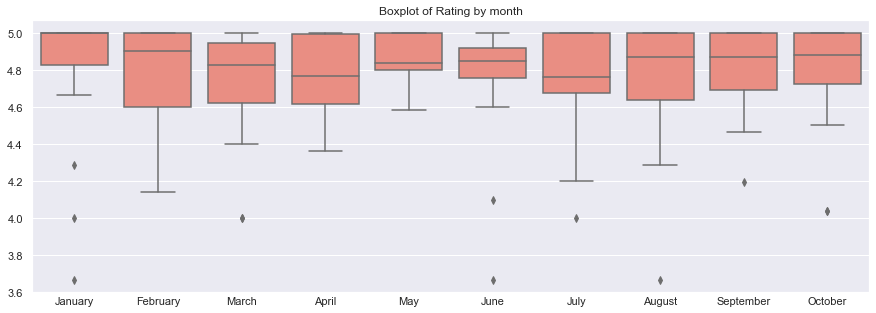

In [44]:
ax = sns.boxplot(data=test, y='Rating', x='dt_month', color='salmon')
ax.set_xticklabels(df_h1['dt_month_name'].unique())
cfg_plot('Boxplot of Rating by month')

In [45]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    #return np.where((ys > upper_bound) | (ys < lower_bound))
    return (ys > upper_bound) | (ys < lower_bound)

In [46]:
test['outlier'] = outliers_iqr(test.Rating)

In [47]:
outliers_days = test[test['outlier'] == True]

In [48]:
outliers_days['dt_dayofweek'].value_counts()

4    3
0    3
2    2
1    2
6    1
5    1
3    1
Name: dt_dayofweek, dtype: int64

In [49]:
outliers_days['Date & Time'].apply(lambda x: x in br_holidays)

0       True
3      False
54     False
72     False
78     False
161    False
179    False
204    False
210    False
212    False
270    False
276    False
282     True
Name: Date & Time, dtype: bool

In [50]:
outliers_days

Date & Time  dt_month  dt_dayofweek    Rating  outlier
0    2017-01-01         1             6  4.000000     True
3    2017-01-04         1             2  3.666667     True
54   2017-02-24         2             4  4.142857     True
72   2017-03-14         3             1  4.000000     True
78   2017-03-20         3             0  4.000000     True
161  2017-06-12         6             0  3.666667     True
179  2017-06-30         6             4  4.100000     True
204  2017-07-25         7             1  4.200000     True
210  2017-07-31         7             0  4.000000     True
212  2017-08-02         8             2  3.666667     True
270  2017-09-30         9             5  4.194444     True
276  2017-10-06        10             4  4.040000     True
282  2017-10-12        10             3  4.037037     True

- Sexta e segunda com 6 datas outliers
- 2 feriados e o primeiro com véspera também

In [51]:
dates_ouliers = outliers_days['Date & Time']
dates_ouliers

0      2017-01-01
3      2017-01-04
54     2017-02-24
72     2017-03-14
78     2017-03-20
161    2017-06-12
179    2017-06-30
204    2017-07-25
210    2017-07-31
212    2017-08-02
270    2017-09-30
276    2017-10-06
282    2017-10-12
Name: Date & Time, dtype: object

In [52]:
rating_all_wout_out = df_h1[~df_h1['Date & Time'].dt.date.isin(dates_ouliers)].groupby(['dt_month_name', 'dt_month'])['Rating'].mean().reset_index()

In [53]:
rating_all_wout_out['%_last_month'] = rating_all_wout_out['%_last_month'] = round((rating_all_wout_out.Rating/rating_all_wout_out.Rating.shift(1).fillna(0) -1)*100, 2).replace(np.inf, 0)
rating_all_wout_out.sort_values('dt_month', inplace=True)
rating_all_wout_out

dt_month_name  dt_month    Rating  %_last_month
3       January         1  4.880383          2.22
2      February         2  4.774194         -0.38
6         March         3  4.780749         -1.31
0         April         4  4.741985          0.00
7           May         5  4.833605          1.11
5          June         6  4.844406          2.12
4          July         7  4.743802         -2.80
1        August         8  4.792208          1.06
9     September         9  4.785137          0.02
8       October        10  4.784360         -1.02

In [54]:
rating_all

dt_month dt_month_name    Rating  %_last_month
0         1       January  4.847222          0.00
1         2      February  4.734139         -2.33
2         3         March  4.760417          0.56
3         4         April  4.741985         -0.39
4         5           May  4.833605          1.93
5         6          June  4.825641         -0.16
6         7          July  4.728495         -2.01
7         8        August  4.784946          1.19
8         9     September  4.752672         -0.67
9        10       October  4.702532         -1.05

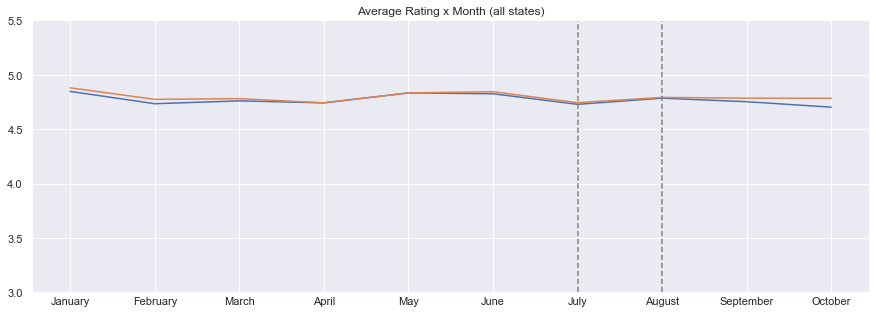

In [55]:
ax = sns.lineplot(x="dt_month", y="Rating", data=rating_all)
ax2 = sns.lineplot(x="dt_month", y="Rating", data=rating_all_wout_out)
plt.xticks(df_h1_month.dt_month.unique())
plt.yticks(np.arange(3, 6, 0.5))
ax.set_xticklabels(df_h1_month.dt_month_name.unique())
plt.axvline(7, color='gray', linestyle='--')
plt.axvline(8, color='gray', linestyle='--')

cfg_plot('Average Rating x Month (all states)')

In [56]:
def plot_heatmap(data, cmap='viridis', annot=True, vmin=0, vmax=5, **kwargs):
    return sns.heatmap(data, annot=annot, cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)

In [57]:
def make_pivot(data, index=[], columns=[], values=['Rating'], aggfunc=np.mean):
    return pd.pivot_table(data, index=index, columns=columns, values=['Rating'], aggfunc=aggfunc, fill_value=-1)

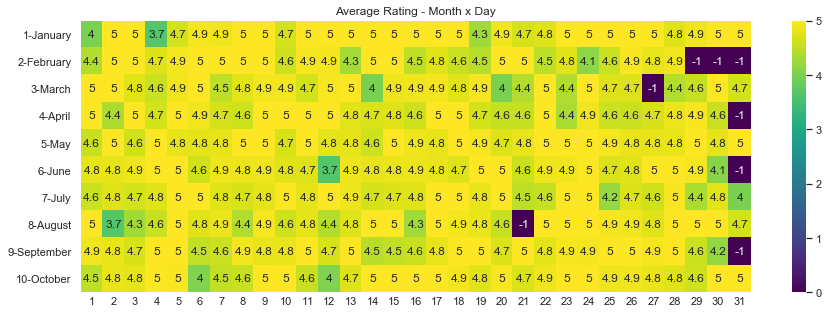

In [58]:
month_day_rating = make_pivot(df_h1, ['dt_month', 'dt_month_name'], ['dt_day'])
month_day_rating.columns = range(1, 32)

plot_heatmap(month_day_rating)
cfg_plot('Average Rating - Month x Day')

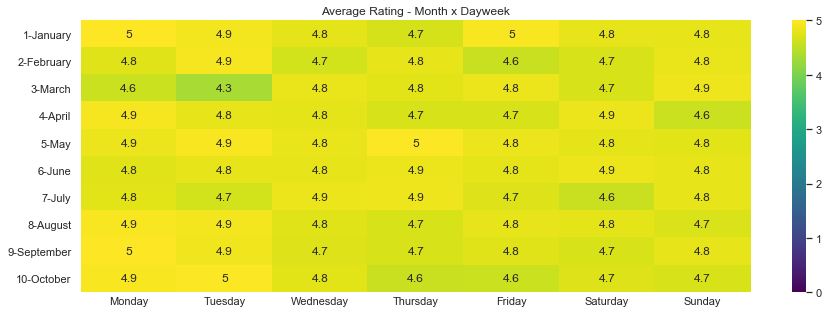

In [59]:
month_dayweek = make_pivot(df_h1, ['dt_month', 'dt_month_name'], ['dt_dayofweek'])
# 0 is Monday
month_dayweek.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plot_heatmap(month_dayweek)
cfg_plot('Average Rating - Month x Dayweek')

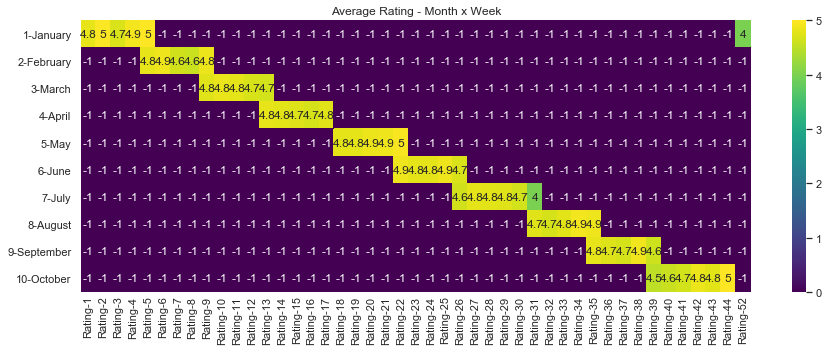

In [60]:
month_week = make_pivot(df_h1, ['dt_month', 'dt_month_name'], ['dt_week'])

plot_heatmap(month_week)
cfg_plot('Average Rating - Month x Week', '', '', 90)

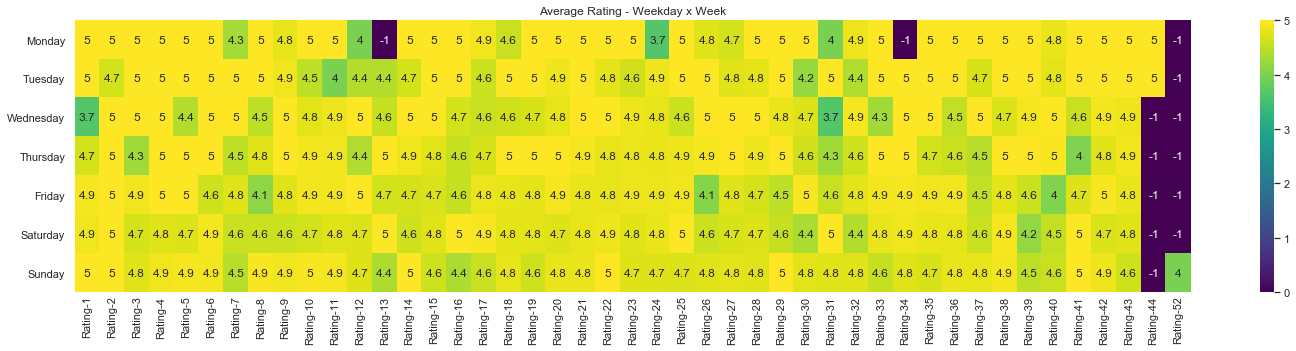

In [61]:
week_dayweek = make_pivot(df_h1, ['dt_dayofweek'], ['dt_week'])
week_dayweek.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots(figsize=(25, 5))
plot_heatmap(week_dayweek, ax=ax)
cfg_plot('Average Rating - Weekday x Week', '', '', 90)

E pras semana ruins, qual foi a nota das distribuidoras?

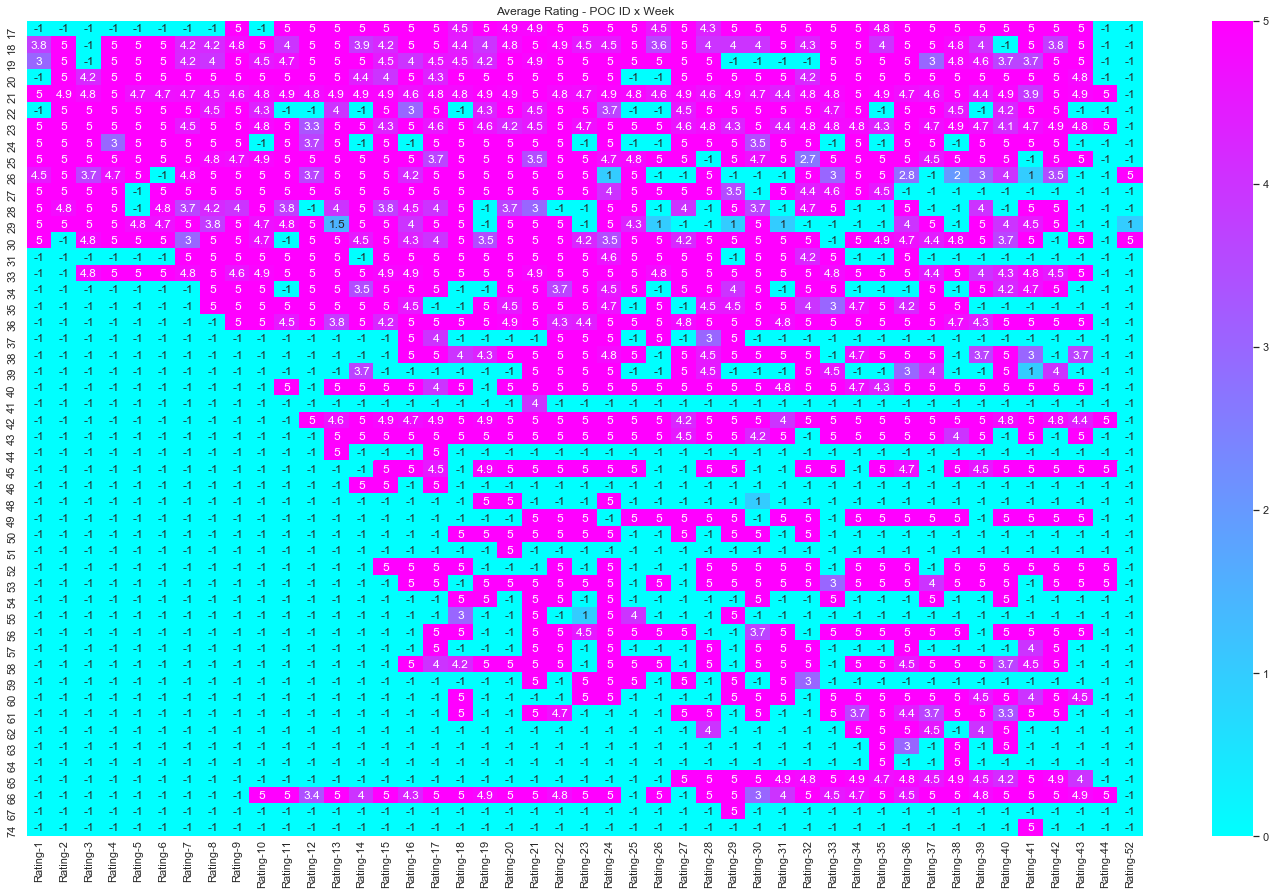

In [62]:
poc_id_rating = make_pivot(df_h1, ['POC ID'], ['dt_week'])

fig, ax = plt.subplots(figsize=(25, 15))
plot_heatmap(poc_id_rating, cmap='cool', ax=ax)
cfg_plot('Average Rating - POC ID x Week', '', '', 90)

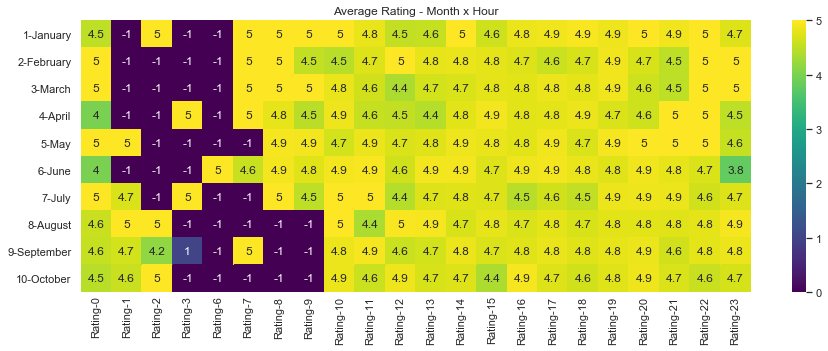

In [63]:
month_hour_rating = make_pivot(df_h1, ['dt_month', 'dt_month_name'], ['tm_hour'])
#month_day_rating.columns = range(1, 32)

plot_heatmap(month_hour_rating)
cfg_plot('Average Rating - Month x Hour', '', '', 90)

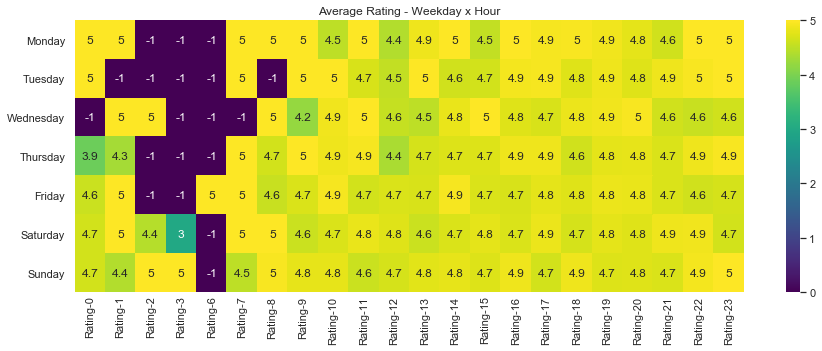

In [64]:
week_hour = make_pivot(df_h1, ['dt_dayofweek'], ['tm_hour'])
week_hour.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

#fig, ax = plt.subplots(figsize=(25, 5))
plot_heatmap(week_hour)
cfg_plot('Average Rating - Weekday x Hour', '', '', 90)

In [65]:
rating = pd.pivot_table(df_h1, index=['POC ID'], columns=['tm_hour'], values=['Rating'], aggfunc=[np.mean], fill_value=-1)
rating.columns = range(1, 23)

In [66]:
size = pd.pivot_table(df_h1, index=['POC ID'], columns=['tm_hour'], values=['Rating'], aggfunc=[np.size], fill_value=-1)
size.columns = range(1, 23)

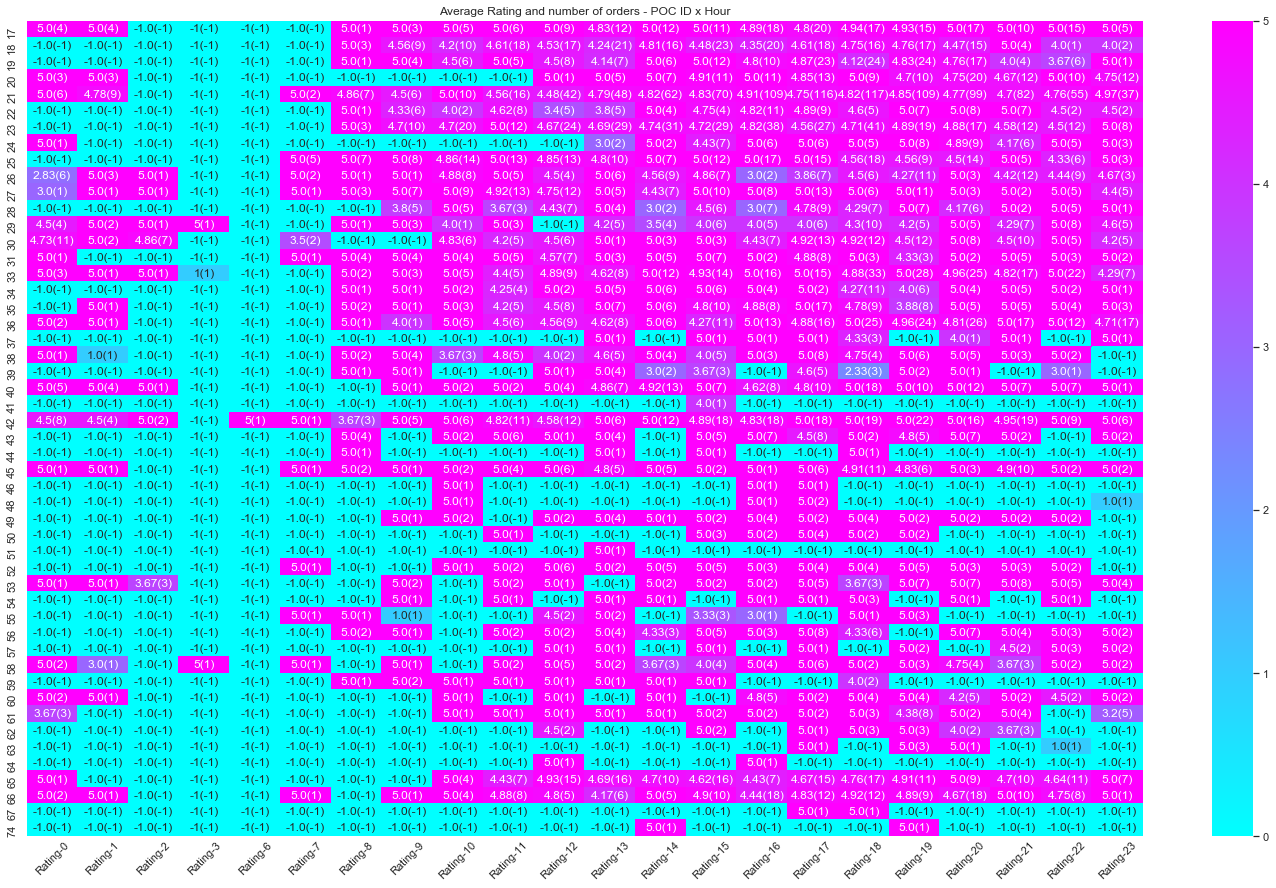

In [67]:
poc_id_rating = make_pivot(df_h1, ['POC ID'], ['tm_hour'])

fig, ax = plt.subplots(figsize=(25, 15))
plot_heatmap(poc_id_rating, cmap='cool', ax=ax, fmt='', annot=rating.apply(lambda x: round(x, 2)).astype(str).add('(').add(size.astype(str)).add(')'))
cfg_plot('Average Rating and number of orders - POC ID x Hour', '', '', 45)

In [68]:
rating = pd.pivot_table(df_h1, index=['POC ID'], columns=['dt_month'], values=['Rating'], aggfunc=[np.mean], fill_value=-1)
rating.columns = range(1, 11)

In [69]:
size = pd.pivot_table(df_h1, index=['POC ID'], columns=['dt_month'], values=['Rating'], aggfunc=[np.size], fill_value=-1)
size.columns = range(1, 11)

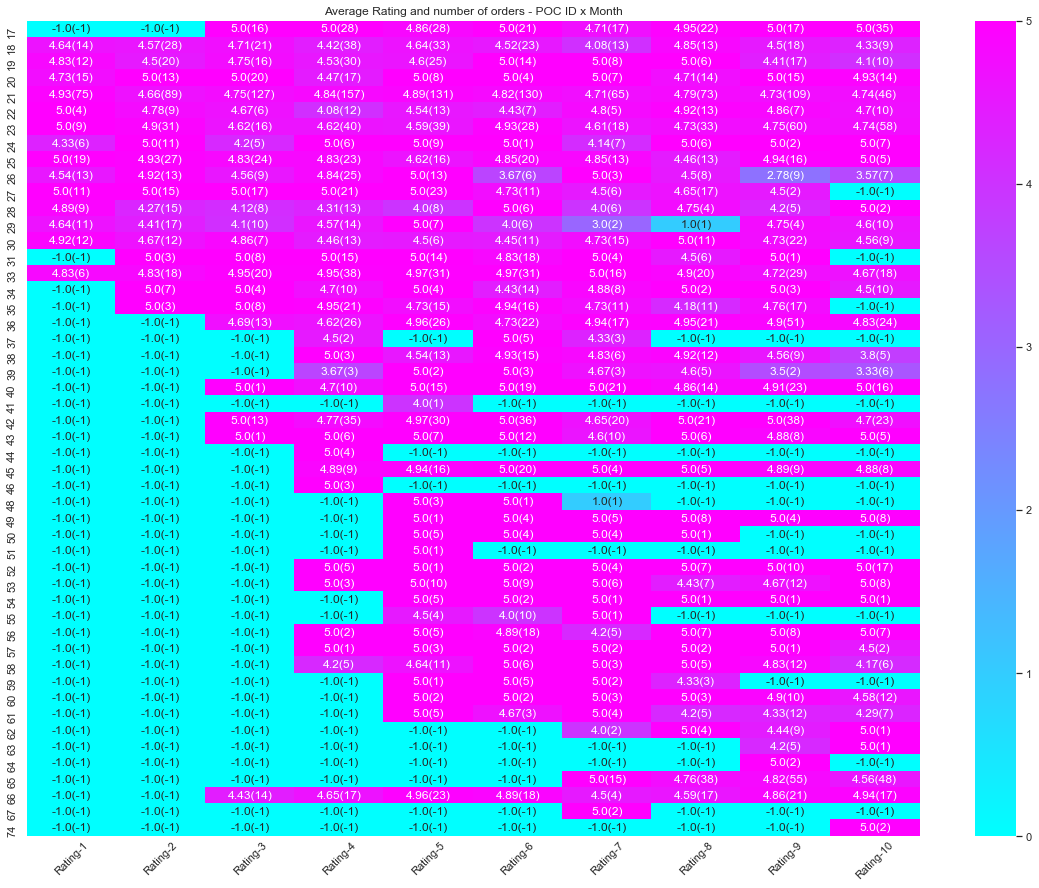

In [70]:
poc_id_rating = make_pivot(df_h1, ['POC ID'], ['dt_month'])

fig, ax = plt.subplots(figsize=(20, 15))
plot_heatmap(poc_id_rating, cmap='cool', ax=ax, fmt='', annot=rating.apply(lambda x: round(x, 2)).astype(str).add('(').add(size.astype(str)).add(')'))
cfg_plot('Average Rating and number of orders - POC ID x Month', '', '', 45)

- Existem algumas médias em 1 da meia noite até as 7 da manhã. Existem boas, mas essas estão marcando.
- Qual o horário de funcionamento desses estabelecimentos?
    - Parece que os melhores horários de rating é no período noturno (depois das 16h até umas 21h ou 22h)
        - Esses estabelecimentos são apenas distribuidoras de bebidas ou fazem o comércio de outros produtos?
        
- Estabelecimentos com horário mais organizado, tem nota melhor?

- Estabelecimentos com poucos pedidos parece que tem uma nota mais baixa. Esses estabelecimentos estão preparados para atender? Como é o treinamento para que esses estabelcimentos comecem a atender pelo zé?

In [71]:
filtered = df[(
    (df['tm_hour'] > 22) | (df['tm_hour'] <= 8)) 
    & (df['Rating'] > 0) 
    & (df['Comment'].notnull()
    & (df['Rating'] != 5)
  )].sort_values(['tm_hour','Rating'], ascending=True)[['Rating', 'rating_reasons', 'Comment', 'tm_hour']]

filtered

Rating  rating_reasons  \
7557      1.0             NaN   
8153      1.0             NaN   
10254     1.0    Não entregue   
7237      3.0     outra coisa   
11151     1.0     outra coisa   
8699      1.0             NaN   
8126      1.0     outra coisa   
9778      1.0    Não entregue   
9891      1.0  mais de 1 hora   
11031     4.0             NaN   

                                                 Comment  tm_hour  
7557                                        Não entregou        0  
8153                                         Não recebi.        0  
10254     1 hora de espera e nada. Proganda enganosa....        0  
7237   eu achei incrível, porém achei o frete caro pr...        0  
11151  A cerveja todas estavam com muita espuma, pare...        1  
8699                                    Não foi entregue        2  
8126   Meu pedido não foi entregue e mesmo após ligar...       23  
9778   Tem pouco mais de uma hora e a cerveja ainda n...       23  
9891   Mais de uma hora e não tinha sido entregue. Ca...       23  
11031      Serviço top! Mas a taxa de entrega é de doer!       23

In [72]:
filtered.fillna('NA').groupby('rating_reasons').size()

rating_reasons
NA                4
Não entregue      2
mais de 1 hora    1
outra coisa       3
dtype: int64

In [73]:
for index, t in enumerate(filtered.Comment):
    print(index, t)

0 Não entregou
1 Não recebi.
2 1 hora de espera e nada. Proganda enganosa....
3 eu achei incrível, porém achei o frete caro pra quem mora perto como eu rs, tipo duas ruas para baixo do local de entrega
4 A cerveja todas estavam com muita espuma, parecendo sabão e as garrafas retornáveis estavam encharcadas de vinagre.
5 Não foi entregue
6 Meu pedido não foi entregue e mesmo após ligar para a adega e enviar DOIS e-mails para o site, o pedido não foi entregue e não tive retorno nenhum por parte do entregador. No último e-mail que recebi do site, me enviaram um novo voucher para efetuar novo pedido. Vamos ver se agora entrega.
7 Tem pouco mais de uma hora e a cerveja ainda não chegou. Estou aguardando.
8 Mais de uma hora e não tinha sido entregue. Cancelei o pedido
9 Serviço top! Mas a taxa de entrega é de doer!


- comentarios do periodo da madrugada
    - nota 1
        - não foi entregue
        - espuma
    - maior que 1
        - taxa de entrega

In [74]:
filtered = df[(
    (df['tm_hour'] > 8) & (df['tm_hour'] <= 22)) 
    & (df['Rating'] > 0) 
    & (df['Comment'].notnull()
    & (df['Rating'] != 5)
  )].sort_values(['Rating', 'tm_hour'], ascending=True)[['Rating', 'rating_reasons', 'Comment', 'tm_hour']]


In [75]:
filtered.fillna('NA').groupby('rating_reasons').size()

rating_reasons
NA                        9
Não entregue              2
cerveja quente            4
faltou produto            2
mais de 1 hora           11
outra coisa              10
problema no pagamento     2
serviço ruim              2
dtype: int64

In [76]:
for row in filtered.iterrows():
    print(row[1]['Rating'], '---', row[1]['tm_hour'],'---', row[1]['rating_reasons'], '---', row[1]['Comment'])

1.0 --- 11 --- outra coisa --- Ainda não recebi
1.0 --- 12 --- mais de 1 hora --- O entregador não quis entrar no condomínio para fazer a entrega, chegou com atraso e sem o troco que eu pedi, pois pagaria em dinheiro.
1.0 --- 12 --- nan --- Não chegou a encomenda
1.0 --- 14 --- mais de 1 hora --- O pedido não foi entregue
1.0 --- 15 --- serviço ruim --- fiz o pedido e não tive retorno
1.0 --- 15 --- outra coisa --- O pedido nunca chegou
1.0 --- 15 --- mais de 1 hora --- Nossa como tudo tem uma primeira vez, eis q tive a minha 1° vez, demora d+!
1.0 --- 15 --- Não entregue --- O pedido não foi realizado.. estamos aguardando e tentamos contato com a distribuidora sem sucesso
1.0 --- 16 --- mais de 1 hora --- Ainda não chegou meu pedido aqui
1.0 --- 16 --- mais de 1 hora --- Não foi entregue
1.0 --- 18 --- cerveja quente --- Primeira vez q peço é a cerveja veio quente pra caramba. Passei vergonha com os convidados. Dificilmente pedirei outra vez
1.0 --- 18 --- mais de 1 hora --- Não receb

- comentarios das 9 as 22
    - nota 1
        - nao entregue
    - nota 2 e 3
        - cerveja quente
        - frete caro

- NPS Score
    - notas de 1-6: defratores
    - notas 7-8: neutros
    - notas 9-10: promotores
    

- NPS (escala de 5)
    - notas de 1-3: defratores
    - nota de 4-5: promotores
    - sem neutros!
        - por que? https://stats.stackexchange.com/questions/114060/calculating-the-net-promoter-score-for-poll-data-on-a-1-5-scale

In [77]:
def calculate_nps(data):
    calc = data['Rating'].apply(lambda x: 'Defractor' if x <= 3 else 'Promoter').value_counts()/data['Rating'].size
    nps = calc['Promoter'] - calc['Defractor']
    return round(nps, 2)

In [78]:
def calculate_nps_agg(serie):
    calc = serie.apply(lambda x: 'Defractor' if x <= 3 else 'Promoter').value_counts()/serie.size
    
    pro = 0
    defr = 0
    
    try:
        pro = calc['Promoter']
        defr = calc['Defractor']
    except:
        pass
    
    nps = pro - defr
    return round(nps, 2)*100

In [79]:
print('NPS de toda a base: ',calculate_nps(df_h1))

NPS de toda a base:  0.88


In [80]:
rating_nps = pd.pivot_table(df_h1, index=['POC ID'], columns=['tm_hour'], values=['Rating'], aggfunc=[calculate_nps_agg], fill_value=-1)
rating_nps.columns = range(0, len(rating_nps.columns))

In [81]:
size_nps = pd.pivot_table(df_h1, index=['POC ID'], columns=['tm_hour'], values=['Rating'], aggfunc=[np.size], fill_value=-1)
size_nps.columns = range(0, len(size_nps.columns))

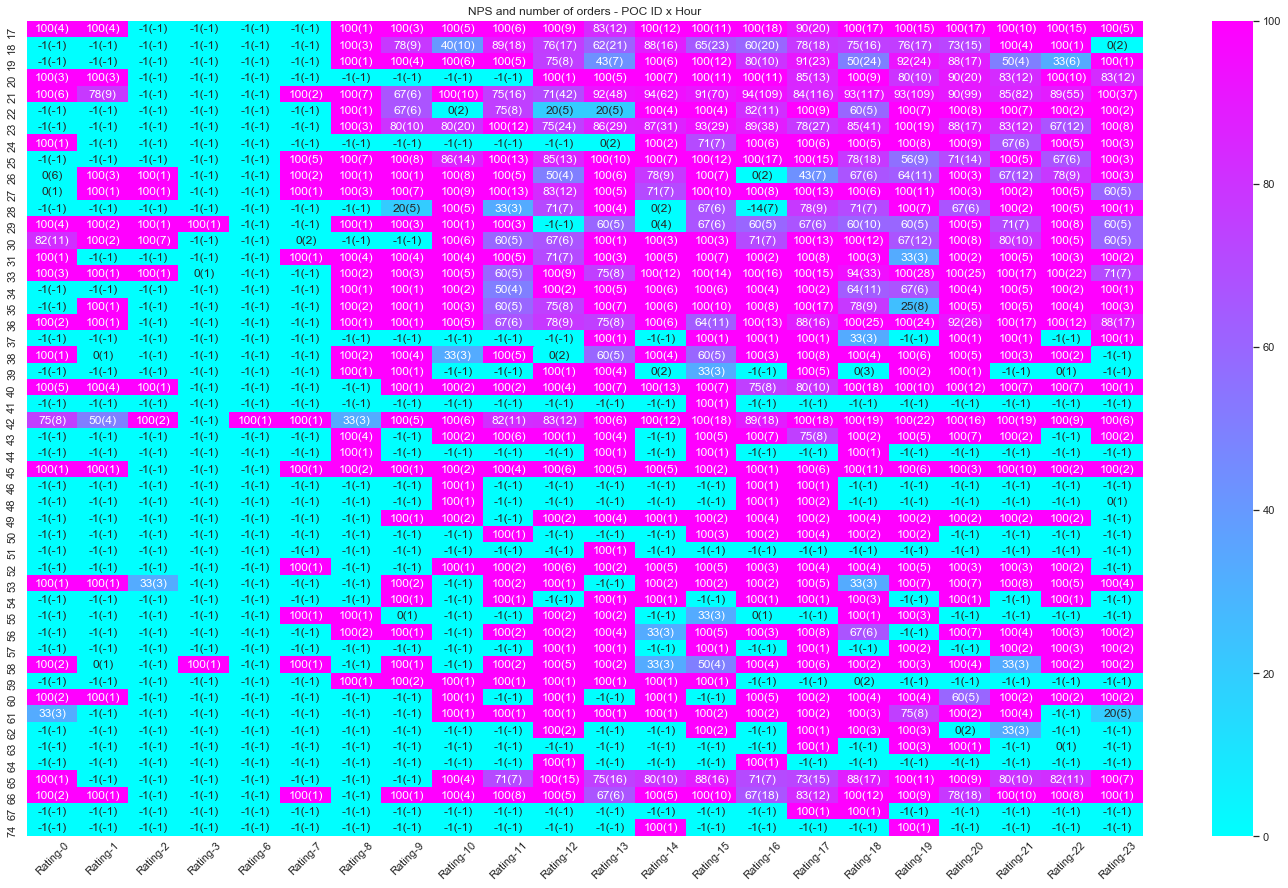

In [82]:
poc_id_rating = make_pivot(df_h1, ['POC ID'], ['tm_hour'], aggfunc=calculate_nps_agg)

fig, ax = plt.subplots(figsize=(25, 15))
plot_heatmap(poc_id_rating, cmap='cool', ax=ax, fmt='', vmin=0, vmax=100, annot=rating_nps.apply(lambda x: round(x, 2)).astype(str).add('(').add(size_nps.astype(str)).add(')'))
cfg_plot('NPS and number of orders - POC ID x Hour', '', '', 45)

___

## Revenue

In [83]:
df_h2 = df[['Rating', 'State', 'Date & Time', 'POC ID','rating_reasons','Merchandise Revenue', 'season'] + [col for col in df.columns if 'dt_' in col] + [col for col in df.columns if 'tm_' in col]]

In [84]:
df_h2['Merchandise Revenue'].describe()

count    11259.000000
mean        99.905259
std        396.488273
min        -19.296000
25%         29.880000
50%         35.424000
75%         59.328000
max       6894.528000
Name: Merchandise Revenue, dtype: float64

In [85]:
def ecdf(data):
    percentiles = []
    n = len(data)
    sort_data = np.sort(data)

    for i in np.arange(1,n+1):
        p = i/n
        percentiles.append(p)
    
    return sort_data, percentiles

In [86]:
x, y = ecdf(df_h2['Merchandise Revenue'])

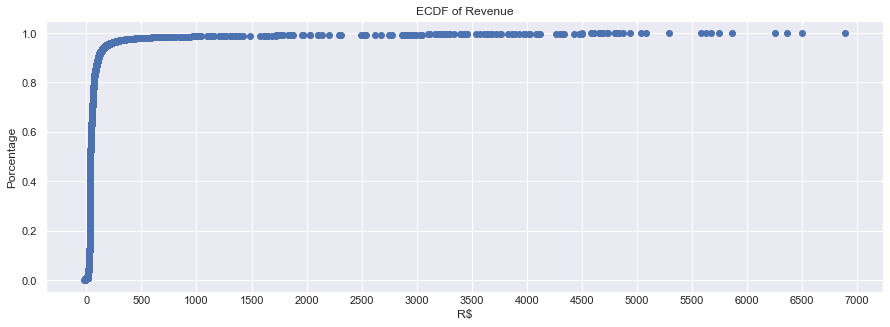

In [87]:
plt.plot(x, y, linestyle='None', marker='o')
plt.xticks(range(0, 7500, 500))
cfg_plot('ECDF of Revenue', 'R$', 'Porcentage')

Existe um viés grande para pedidos de valor baixo.

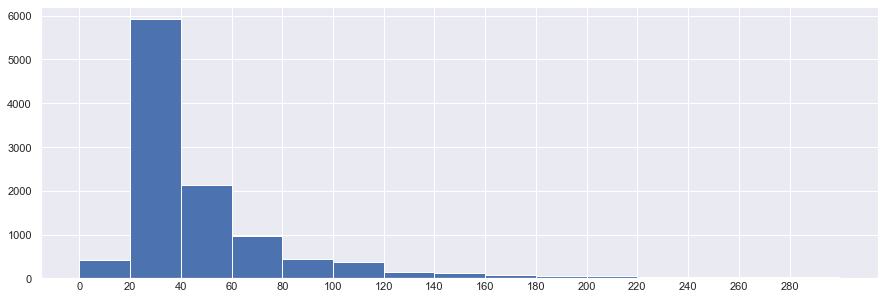

In [133]:
plt.hist(df_h2['Merchandise Revenue'], range=(0, 300), bins=15)
plt.xticks(range(0, 300, 20))
cfg_plot('')

In [89]:
df_h2['Merchandise Revenue'].quantile(0.66)

48.69696000000002

66% da base tem Revenue de até 50,00

In [90]:
df_h2['Merchandise Revenue'].quantile(.95)

182.55840000000006

95% da base tem Revenue de até 182,00

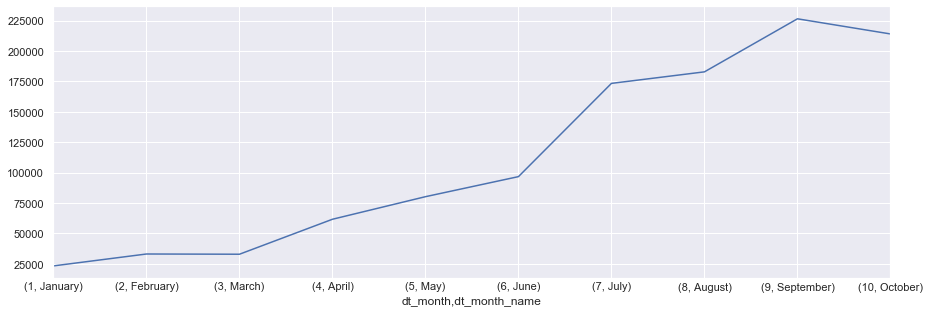

In [91]:
df_h2.groupby(['dt_month', 'dt_month_name'])['Merchandise Revenue'].sum().plot()

In [92]:
month_revenue = df_h2.groupby(['dt_month', 'dt_month_name']).agg({
    'Merchandise Revenue':['sum', 'size']})

In [93]:
month_revenue.columns = ['sum', 'size']

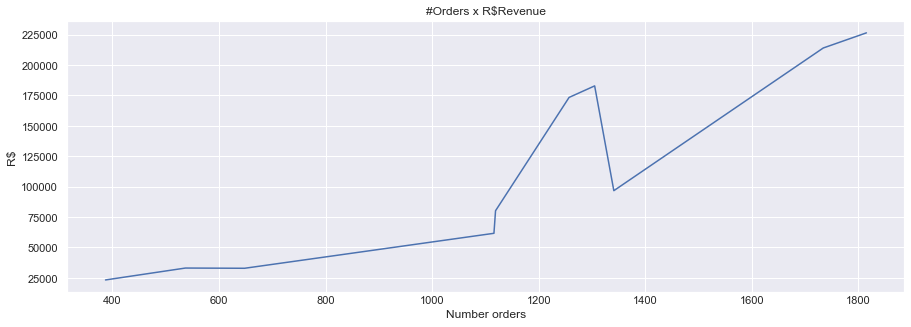

In [94]:
sns.lineplot(data=month_revenue, y='sum', x='size')
cfg_plot('#Orders x R$Revenue', 'Number orders', 'R$')

In [95]:
month_revenue['sum_abrev'] = (month_revenue['sum']/1000).astype(int).astype('str')+'K'

In [96]:
month_revenue = month_revenue.reset_index()

In [97]:
month_revenue

dt_month dt_month_name         sum  size sum_abrev
0         1       January   23310.672   387       23K
1         2      February   33096.896   537       33K
2         3         March   32908.160   648       32K
3         4         April   61670.664  1116       61K
4         5           May   80232.440  1119       80K
5         6          June   96725.952  1341       96K
6         7          July  173410.752  1257      173K
7         8        August  182895.544  1305      182K
8         9     September  226516.744  1815      226K
9        10       October  214065.488  1734      214K

In [98]:
month_revenue['mean_order_revenue'] = month_revenue['sum']/month_revenue['size']

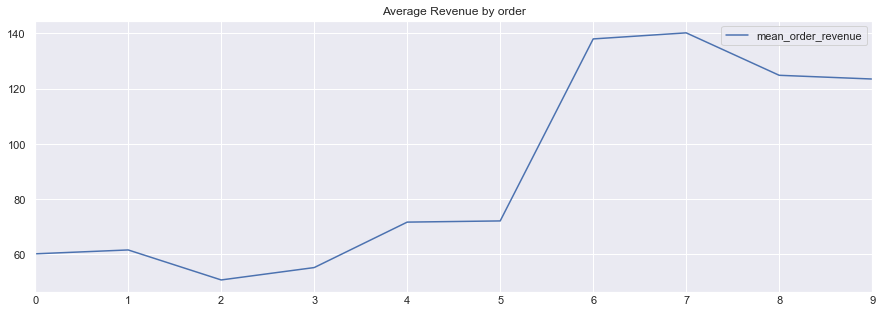

In [99]:
month_revenue[['mean_order_revenue']].plot()
cfg_plot('Average Revenue by order')

O que aconteceu de junho pra julho? Houve mudança ou é um outlier?

In [100]:
agg_rev = df_h1.groupby([df_h1['Date & Time'].dt.date, 'dt_month', 'dt_dayofweek']).mean()['Rating'].reset_index()

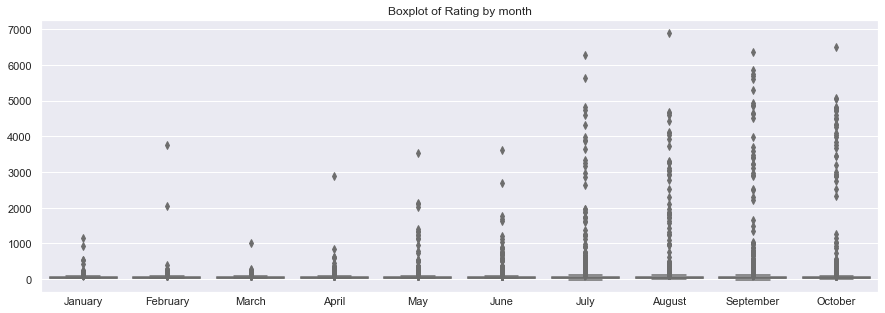

In [101]:
ax = sns.boxplot(data=df_h2, y='Merchandise Revenue', x='dt_month', color='salmon')
ax.set_xticklabels(df_h2['dt_month_name'].unique())
cfg_plot('Boxplot of Rating by month')

In [102]:
df_h2['out_revenue'] = outliers_iqr(df_h2['Merchandise Revenue'])

C:\Users\marco\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


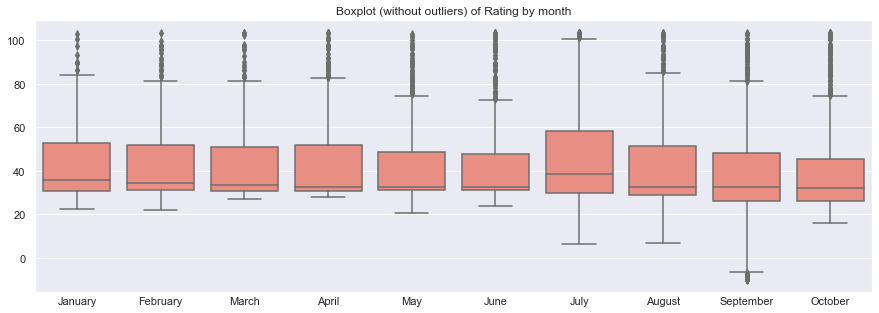

In [103]:
ax = sns.boxplot(data=df_h2[df_h2['out_revenue']==False], y='Merchandise Revenue', x='dt_month', color='salmon')
ax.set_xticklabels(df_h2['dt_month_name'].unique())
cfg_plot('Boxplot (without outliers) of Rating by month')

In [104]:
df_h2_wout_out = df_h2[df_h2['out_revenue']==False]

In [105]:
df_h2_wout_out['Merchandise Revenue'].quantile(0.66)

41.77344000000001

66% da base tem Revenue de até 50,00

In [106]:
df_h2_wout_out['Merchandise Revenue'].quantile(.95)

81.12

95% da base tem Revenue de até 182,00

In [107]:
x, y = ecdf(df_h2_wout_out['Merchandise Revenue'])

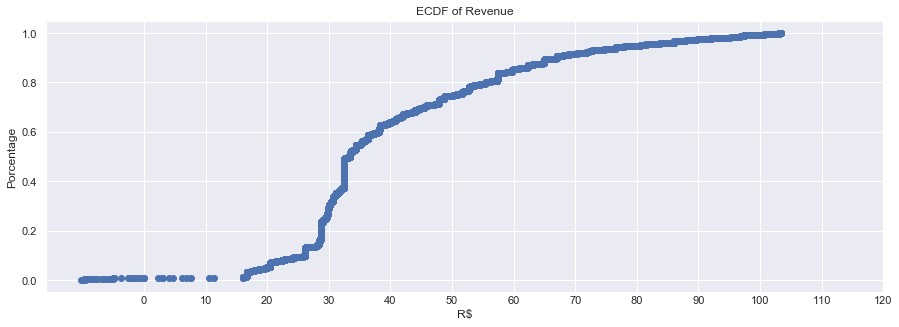

In [108]:
plt.plot(x, y, linestyle='None', marker='o')
plt.xticks(range(0, 130, 10))
cfg_plot('ECDF of Revenue', 'R$', 'Porcentage')

In [109]:
@interact(state=df_h2.State.unique(), with_outliers=True)
def plot_rating_day_month(state, with_outliers):
    ax = sns.boxplot(data=df_h2[(df_h2['State']==state) & (df_h2['out_revenue']==with_outliers)], y='Merchandise Revenue', x='dt_month', color='salmon')
    ax.set_xticklabels(df_h2['dt_month_name'].unique())
    cfg_plot('Revenue x Month x State')

interactive(children=(Dropdown(description='state', options=('SP', 'RJ', 'MG', 'CE', 'PR', 'NA'), value='SP'),…

## Orders

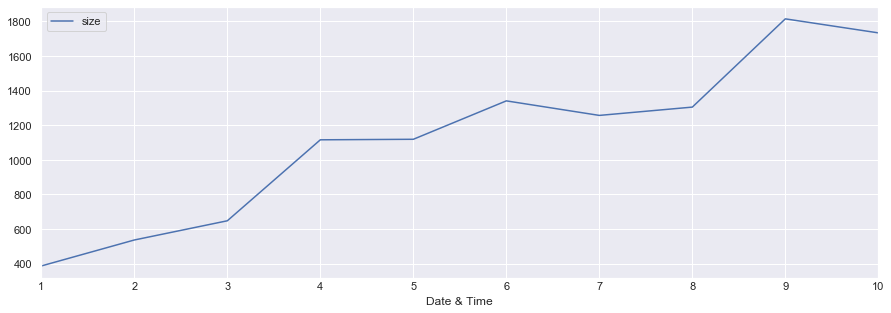

In [110]:
df_h2.groupby([df_h2['Date & Time'].dt.month]).size().to_frame('size').plot()

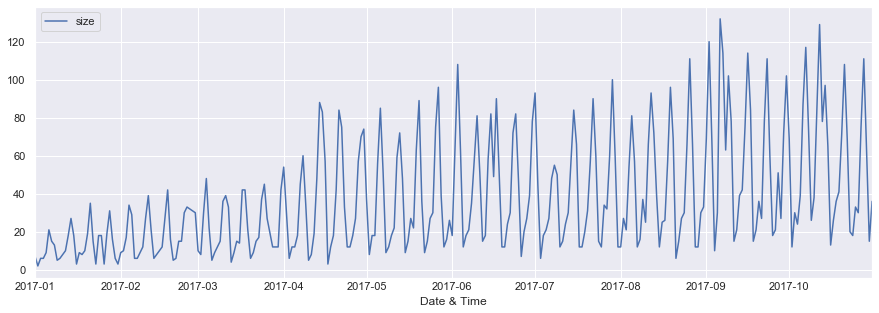

In [111]:
size_day = df_h2.groupby([df_h2['Date & Time'].dt.date]).size().to_frame('size')
size_day.plot()

Time Series detected! Qual a tendência dessa ts?

In [112]:
size_day

size
Date & Time      
2017-01-01      7
2017-01-02      2
2017-01-03      6
2017-01-04      6
2017-01-05      9
...           ...
2017-10-27     75
2017-10-28    111
2017-10-29     63
2017-10-30     15
2017-10-31     36

[303 rows x 1 columns]

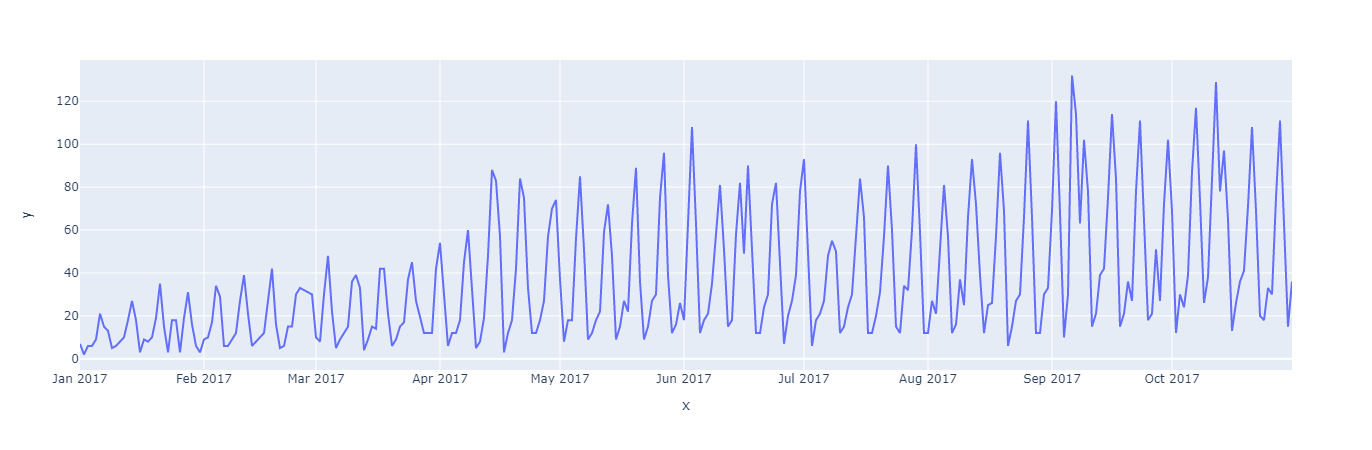

In [129]:
fig = px.line(x=size_day.index, y=size_day['size'])
fig.show()

Picos a cada 7 dias. Em quais dias da semana isso acontece (sexta? sábado?)

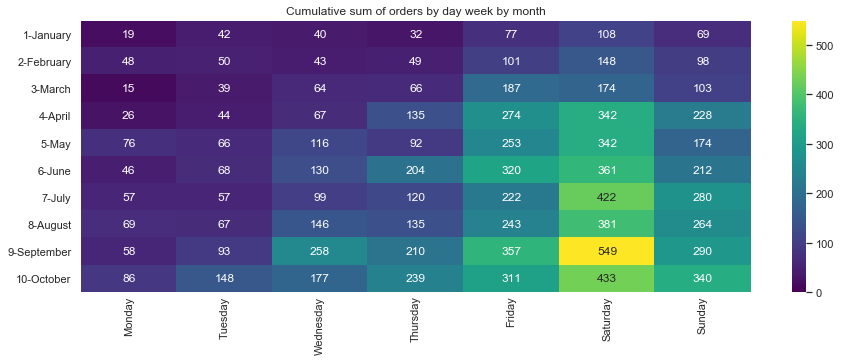

In [114]:
month_dayweek = pd.pivot_table(df_h2, index=['dt_month', 'dt_month_name'], columns=['dt_dayofweek'], values=['POC ID'], aggfunc=np.size, fill_value=-1)
month_dayweek.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plot_heatmap(month_dayweek, vmin=0, vmax=month_dayweek.max().max(), fmt='g')
cfg_plot('Cumulative sum of orders by day week by month', '', '', 90)

Potencial a ser explorado: **Quarta-feira! Dia de futebol!**

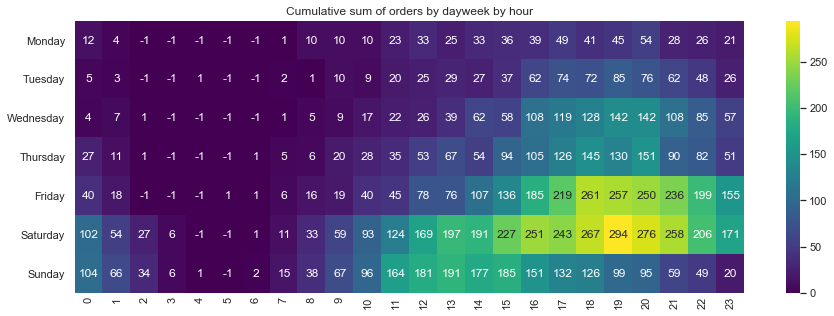

In [115]:
hour_dayweek = pd.pivot_table(df_h2, index=['dt_dayofweek'], columns=['tm_hour'], values=['POC ID'], aggfunc=np.size, fill_value=-1)
hour_dayweek.columns = range(0, 24)
hour_dayweek.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plot_heatmap(hour_dayweek, vmin=0, vmax=hour_dayweek.max().max(), fmt='g')
cfg_plot('Cumulative sum of orders by dayweek by hour', '', '', 90)

- Quarta das 19 as 20 tem um aumento consideravel, mas será que não poderia ser melhor?
    - Os números estão próximos da quinta-feira
- Domingo há pedidos praticamente o dia inteiro. Domingo é um dia propício para consumo de cerveja: churrasco e futebol com 2 horários no mesmo dia (sem contar série B)
    - Incentivar os pedidos no domingo pode melhorar esses números

E quanto aos meses frios? Estações do ano?

In [116]:
@interact(season=df_h2.season.unique())
def order_dayweek_month(season):
    hour_dayweek = pd.pivot_table(df_h2[df_h2['season']==season], index=['dt_dayofweek'], columns=['tm_hour'], values=['POC ID'], aggfunc=np.size, fill_value=-1)
   # hour_dayweek.columns = range(0, 24)
    hour_dayweek.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    plot_heatmap(hour_dayweek, vmin=0, vmax=hour_dayweek.max().max(), fmt='g')
    cfg_plot('Cumulative sum of orders by dayweek by hour', '', '', 90)


interactive(children=(Dropdown(description='season', options=('winter', 'spring', 'summer', 'autumn'), value='…

In [117]:
df_h2.groupby(['season', 'State'])['POC ID'].size().to_frame('size').reset_index()

season State  size
0   autumn    CE    17
1   autumn    MG   162
2   autumn    NA   198
3   autumn    PR    31
4   autumn    RJ   573
5   autumn    SP  1215
6   spring    CE    51
7   spring    MG   232
8   spring    PR    58
9   spring    RJ   559
10  spring    SP  2478
11  summer    CE    83
12  summer    MG   300
13  summer    NA   324
14  summer    PR    73
15  summer    RJ   967
16  summer    SP  2594
17  winter    MG    11
18  winter    RJ    72
19  winter    SP  1261

Não houve pedido para o Ceará nesse período. Queria ver se a quantidade de pedidos diminuia muito.

In [118]:
import statsmodels.api as sm

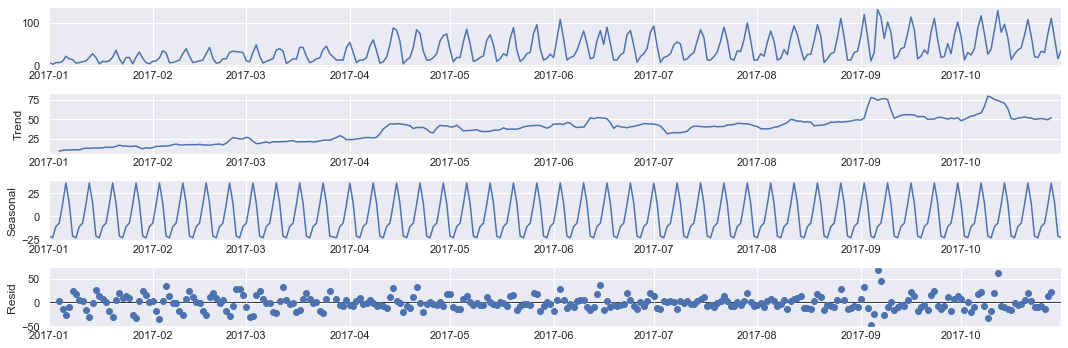

In [119]:
decomposition = sm.tsa.seasonal_decompose(size_day, period=7)
fig = decomposition.plot()

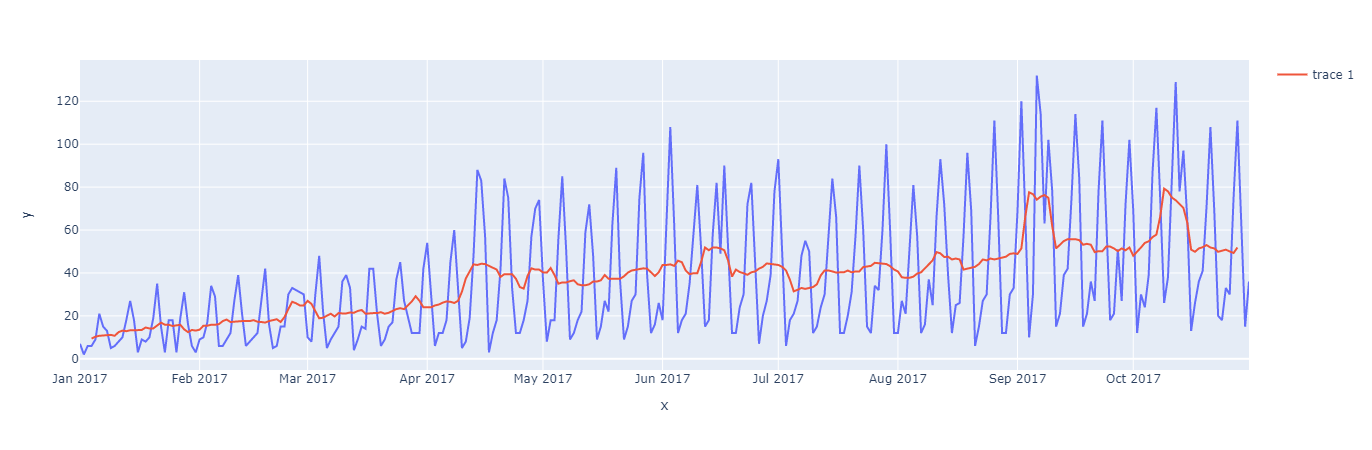

In [120]:
fig = px.line(x=size_day.index, y=size_day['size'])
fig.add_scatter(x=decomposition.trend.index, y=decomposition.trend, mode='lines')

fig.show()

Acompanhando a tendencia, para Agosto que foi o começo da campanha, houve uma subida e em setembro e outubro há uma subida por conta do feriado, mas existe uma tendência flat.